In [131]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
import torchvision.transforms as transforms
from torchvision import datasets
import pathlib
import project.utils as utils
from functools import partial
import project.augmentations as aug_lib
from collections import defaultdict
import ood_detectors.vision as vision_ood

%load_ext autoreload
%autoreload 2
%matplotlib widget


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install -U ood_detectors

In [122]:
mode = 'ITGAN'
dataset = 'CIFAR10'
model_name = "resnet18.a1_in1k"
exp = 0
root_path = pathlib.Path('/mnt/data/arty/data/IT-GAN')
data_path = root_path / 'data' 
checkpoint_path = root_path / 'checkpoints' 
weight_path = checkpoint_path / f"G_Pretrained_{dataset}_exp{exp}.pth"
shuffle = True
pretrained=False
augmentations = 'color_crop_cutout_flip_scale_rotate'
aug = partial(aug_lib.diff_augment, strategy=augmentations, param=aug_lib.ParamDiffAug())
device = 'cuda'
drop_rate = 0.1
num_workers = 0
batch_size = 128
encoder_dim = 768
classifier_load_path = checkpoint_path / f"{model_name}_{dataset}.pth"


In [123]:
data = utils.get_dataset(dataset, data_path, None)

Files already downloaded and verified
Files already downloaded and verified


In [124]:
anchors = utils.load_anchors(checkpoint_path / f'Base_ITGAN_{dataset}_exp{exp}.pt')

In [125]:
generator, mean, std = utils.load_generator(*anchors[2:], weight_path)

In [126]:

train_img = data["train"]
anchor_emb = anchors[0]
label = anchors[1]

data_blob = defaultdict(list)
for img, l, i in train_img:
    emb = anchor_emb[i]
    data_blob[int(l)].append((img, emb))

In [133]:
encoder = vision_ood.get_encoder("dinov2")
encoder.eval()
encoder.to(device)
encoder_name = encoder.name

encoder_gen_loader = utils.TransformLoader(utils.GeneratorDatasetLoader(*anchors, weight_path, shuffle=False, num_workers=0, batch_size=batch_size, device=device, use_cache=False), utils.get_transforms(encoder, 'Encoder'), device=device)
encoder_real_loader = utils.TransformLoader(torch.utils.data.DataLoader(data['train'], batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=utils.imge_stack), utils.get_transforms(encoder, 'Real'), device=device)

Using cache found in /DCS/tmp/torch/hub/facebookresearch_dinov2_main
/DCS/tmp/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/DCS/tmp/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/DCS/tmp/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [132]:
embeddings = {}
for k, v in data_blob.items():
    embeddings[k] = torch.zeros((len(v), encoder_dim))
    print(k, len(v))

6 5000
9 5000
4 5000
1 5000
2 5000
7 5000
8 5000
3 5000
5 5000
0 5000


In [ ]:
for emb, loader, name in zip([embeddings_real, embeddings_gen], 
                       [encoder_real_loader, encoder_gen_loader,], 
                       ['real', 'gen', ]):
    if (checkpoint_path/f'embeddings_{name}_{dataset}_{encoder_name}.pt').exists():
        emb[:] = torch.load(checkpoint_path/f'embeddings_{name}_{dataset}_{encoder_name}.pt')
    else:
        for x, y, idx in tqdm.tqdm(loader):
            x = x.to(device)
            with torch.no_grad():
                emb[idx] = encoder(x).detach().cpu()
        torch.save(emb, checkpoint_path / f'embeddings_{name}_{dataset}_{encoder_name}.pt')


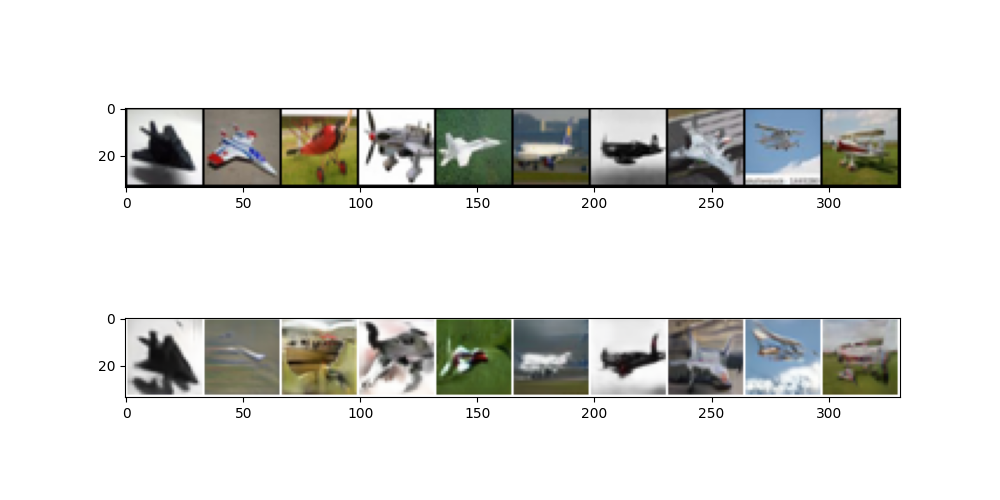

In [128]:
label = 0
samples = 10
img, emb = data_blob[label][0]
torch_label = torch.tensor([label]).to(device)
mean = mean.to(device)
std = std.to(device)
generator = generator.to(device).eval()
batch_emb = torch.stack([e for _, e in data_blob[label][:samples]]).to(device)
labels = torch.tensor([label]*len(batch_emb)).to(device)
torch_img = utils.generate(generator, batch_emb, labels, mean, std).cpu().detach()
gen_imgs = torchvision.utils.make_grid(torch_img, nrow=samples, padding=1, pad_value=1)
org_imgs = torchvision.utils.make_grid(torch.stack([torch.from_numpy(np.array(i)).permute(2,0,1) for i, _ in data_blob[label][:samples]]), nrow=samples, padding=1, pad_value=1)
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[1].imshow(gen_imgs.permute(1, 2, 0))
ax[0].imshow(org_imgs.permute(1, 2, 0))


plt.show()


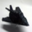

In [129]:
img

In [130]:
gen_img

tensor([[[0.0441, 0.0542, 0.0837,  ..., 0.7975, 0.8222, 0.8433],
         [0.0641, 0.1327, 0.1521,  ..., 0.8238, 0.8585, 0.8456],
         [0.0673, 0.1555, 0.1243,  ..., 0.8628, 0.8812, 0.8889],
         ...,
         [0.4365, 0.4787, 0.5186,  ..., 0.1142, 0.0750, 0.0587],
         [0.3594, 0.3807, 0.4397,  ..., 0.0858, 0.0769, 0.0492],
         [0.4983, 0.5021, 0.5152,  ..., 0.1736, 0.1270, 0.1052]],

        [[0.0899, 0.1001, 0.1428,  ..., 0.6109, 0.6235, 0.7106],
         [0.1600, 0.2492, 0.2748,  ..., 0.6674, 0.6698, 0.7005],
         [0.1856, 0.3095, 0.2627,  ..., 0.7470, 0.7371, 0.7364],
         ...,
         [0.3668, 0.3935, 0.3245,  ..., 0.1228, 0.0836, 0.0725],
         [0.3011, 0.3421, 0.3029,  ..., 0.1109, 0.0946, 0.0625],
         [0.4368, 0.4512, 0.3879,  ..., 0.2392, 0.1740, 0.1135]],

        [[0.2179, 0.2656, 0.2948,  ..., 0.6772, 0.7266, 0.7664],
         [0.3870, 0.4233, 0.4170,  ..., 0.7336, 0.7825, 0.7825],
         [0.3983, 0.4772, 0.4045,  ..., 0.7914, 0.8532, 0.